In [79]:
import torch 
import torch.nn as nn 

import math

from torch.autograd import Variable

import torch.nn.functional as F

# Embedding

In [30]:
# Embedding
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    
    def forward(self, x):
        # 这里乘d_model的平方根是为了防止之后得到的点积结果过大（让结果的大小和d产生关系）
        return self.lut(x) * math.sqrt(self.d_model)

In [110]:
emb = Embeddings(512, 1000)

# x是text通过词汇映射后的数字张量
# x = Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]]))
x = torch.LongTensor([[100,2,421,508],[491,998,1,221]])

embr = emb(x)
print('embr:', embr)
print(embr.shape)

embr: tensor([[[-28.9699,  28.8374,  16.0341,  ...,  21.3994, -19.9581,  19.3659],
         [-12.6224, -33.3315,  42.1398,  ...,   5.5705,   0.5436,   5.7804],
         [-17.6754, -23.3227,  -7.1241,  ...,  12.2310,  32.8686,   0.0564],
         [  2.3801,  -5.9485, -15.0082,  ...,  -7.1975,   2.4692,  41.3163]],

        [[  2.4995, -16.9048, -23.6063,  ...,  -3.6650,  12.2115,  16.8586],
         [-10.3134,  -0.3492,  -4.7883,  ...,   7.0119,  15.4090, -19.7313],
         [-25.0513,  11.7636,   2.6530,  ...,  30.4979,   0.9063,  11.5846],
         [  0.2590,  23.5723,   2.8551,  ...,  22.3362,  -3.3885, -51.9169]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


practice

In [40]:
class Embedding(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model) # 注意参数顺序，先是vocab再是d_model
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model) # self.d_model注意self


In [41]:
emb = Embedding(512, 1000)
x = Variable(torch.LongTensor([[123,456,789,444],[123,123,123,444]]))
embr = emb(x)

embr, embr.shape

(tensor([[[ 25.3110,  -2.7851,  30.2216,  ..., -13.8080, -14.4813, -12.8123],
          [ -1.3550, -26.4017, -10.4651,  ..., -17.2022,  -6.7288,  65.2268],
          [ 19.5472, -17.9188,  10.3435,  ...,   7.9842, -11.3172, -20.1226],
          [  3.2394,  31.9027,   2.3687,  ...,  -8.6424,  22.1775, -55.5508]],
 
         [[ 25.3110,  -2.7851,  30.2216,  ..., -13.8080, -14.4813, -12.8123],
          [ 25.3110,  -2.7851,  30.2216,  ..., -13.8080, -14.4813, -12.8123],
          [ 25.3110,  -2.7851,  30.2216,  ..., -13.8080, -14.4813, -12.8123],
          [  3.2394,  31.9027,   2.3687,  ...,  -8.6424,  22.1775, -55.5508]]],
        grad_fn=<MulBackward0>),
 torch.Size([2, 4, 512]))

# Positional Encoding

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout) # 继承并实例化dropout方法

        # 初始化位置编码矩阵，shape(max_len, x, d_model) 之前的5000保证这里有足够的行
        # pe：positional embedding
        pe = torch.zeros(max_len, d_model)
        # 初始化绝对位置矩阵, shape(max_len, x, 1)，需要通过变换矩阵div_term转换维度到和初始化位置编码矩阵相同
        position = torch.arange(0, max_len).unsqueeze(1) ##准备了token这么d多个位置，给pos做准备

        div_term = torch.exp(torch.arange(0, d_model, 2)* # 这里2说明是跳跃取了一半的值，而不是连续取全部的值，和后面sin/cos对应（每次处理一半）；
                             -(math.log(10000.0)/d_model)) # 这里乘的是一个缩放的项(对应的公式中sin/cos的计算，前面的exp和后面的log抵消，对应的是e的对数和ln)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0) 

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], # 真实文本中不需要很多行，所以就提取这些列就可以了
                         requires_grad=False)
        return self.dropout(x)


In [75]:
pe = PositionalEncoding(d_model=512, dropout=0.1, max_len=60)
x = embr
pe_result = pe(x)
print(pe_result)

tensor([[[  8.7440,  -0.0000, -22.2175,  ...,  -0.0000,  -1.9133, -23.7333],
         [-28.4508, -40.4319,  -5.9083,  ..., -20.9008,  38.4896, -30.3848],
         [ 24.1922, -10.6399, -25.2652,  ...,   5.0809, -12.5333,  56.6777],
         [ 12.7050, -28.6932,   8.7650,  ...,  10.3732, -45.7684, -22.8124]],

        [[ 10.3935, -30.7260,  -8.7050,  ...,   4.7604,  24.0184,  42.8854],
         [-25.8154,  27.6331,  24.5431,  ...,  36.2785,  24.1297,  -3.6109],
         [  2.3628,  -5.7436,   1.7906,  ..., -16.0706,  28.7144, -13.3701],
         [ 18.2173, -34.0497,  21.9660,  ...,   0.0000, -25.6206,  -4.7242]]],
       grad_fn=<MulBackward0>)


practice⬇️

In [34]:
class Positionalencoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1) #unsqueeze注意拼写

        div_term = torch.exp(torch.arange(0, d_model, 2) * #注意是d_model而不是max_len
                             -(math.log(10000)/d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0) # unsqueeze注意拼写（不要忘记q之后的u）

        self.register_buffer('pe', pe) #注册名字为pe，内容为pe

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        return self.dropout(x)

In [36]:
pe = Positionalencoding(d_model=512, dropout=0.1, max_len=60)
x = embr
pe_result = pe(x)

pe_result, pe_result.shape

(tensor([[[  8.7440,  -0.0000, -22.2175,  ..., -24.4560,  -1.9133, -23.7333],
          [-28.4508, -40.4319,  -0.0000,  ..., -20.9008,  38.4896, -30.3848],
          [ 24.1922, -10.6399, -25.2652,  ...,   0.0000, -12.5333,   0.0000],
          [ 12.7050,  -0.0000,   8.7650,  ...,   0.0000, -45.7684, -22.8124]],
 
         [[ 10.3935, -30.7260,  -8.7050,  ...,   4.7604,  24.0184,  42.8854],
          [-25.8154,  27.6331,  24.5431,  ...,  36.2785,  24.1297,  -3.6109],
          [  2.3628,  -5.7436,   1.7906,  ..., -16.0706,  28.7144, -13.3701],
          [ 18.2173, -34.0497,  21.9660,  ...,   5.3807, -25.6206,  -4.7242]]],
        grad_fn=<MulBackward0>),
 torch.Size([2, 4, 512]))

可视化（词向量中特征的分布曲线）

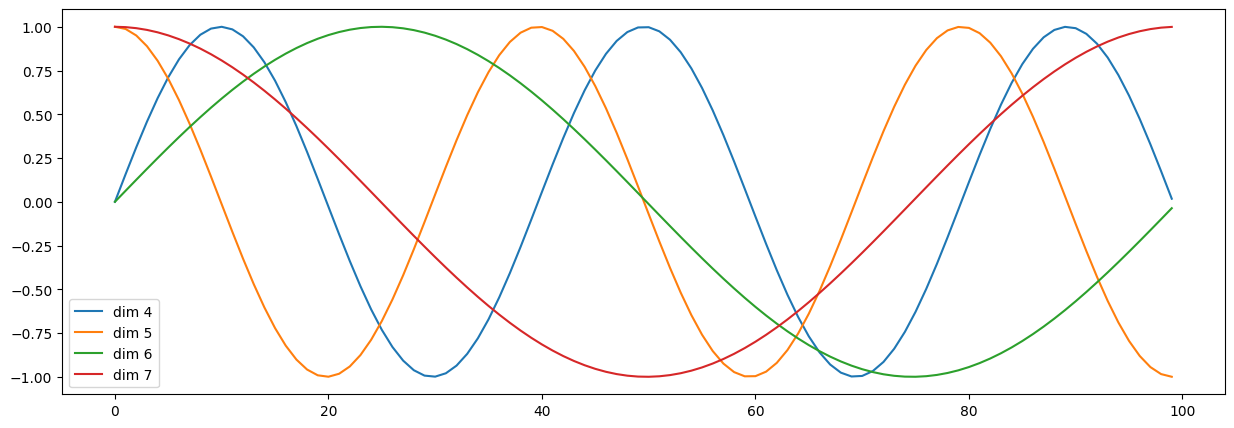

In [38]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

pe_1 = PositionalEncoding(20,0)

y = pe_1(Variable(torch.zeros(1,100,20))) #创建了一个形状为[1,100,20]的全零张量

plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())

plt.legend(['dim %d'%p for p in [4,5,6,7]])

## mask tensor

In [65]:
def subsequent_mask(size): #注意拼写sub中间是u
    # size代表掩码张量的后两个维度
    attn_shape = (1, size, size) #定义掩码张量形状

    # 在attn_shape中添加1元素，形成上三角阵，为了节约空间变换数据类型为无符号8位整形unit8（因为掩码张量中只含有0/1，所以不需要32/64位编码，8位就够了）
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')

    # 上三角转化成下三角（元素只有0/1，所以用1减可以实现转换）
    return torch.from_numpy(1 - subsequent_mask) #把np数组转换为pytorch张量

drafts（triu函数的作用，k的设置）

In [51]:
tensor = [[1,1,1],[1,1,1],[1,1,1]]

tensor = np.array(tensor) #np中使用的是array，下述经过np处理的内容基本都会变成array形式（所以这里把原始的list in list转化成array为了方便比较）
tensor0 = np.triu(tensor)
tensor1 = np.triu(tensor, k=1)
tensor2 = np.triu(tensor, k=0) #默认的是k=0
tensor3 = np.triu(tensor, k=-1)

tensor4 = torch.from_numpy(1 - tensor1) #上下三角的转换

tensor, tensor0, tensor1, tensor2, tensor3, tensor1, tensor4

(array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 array([[1, 1, 1],
        [0, 1, 1],
        [0, 0, 1]]),
 array([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]]),
 array([[1, 1, 1],
        [0, 1, 1],
        [0, 0, 1]]),
 array([[1, 1, 1],
        [1, 1, 1],
        [0, 1, 1]]),
 array([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]]),
 tensor([[1, 0, 0],
         [1, 1, 0],
         [1, 1, 1]]))

practice⬇️

In [53]:
def mask_function(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')

    return torch.from_numpy(1 - subsequent_mask)

In [54]:
mask = mask_function(5)
mask

tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)

可视化掩码（黄色代表1，被遮住。比如说从第三个横坐标位置看，只有0-2是紫色的能看到的）

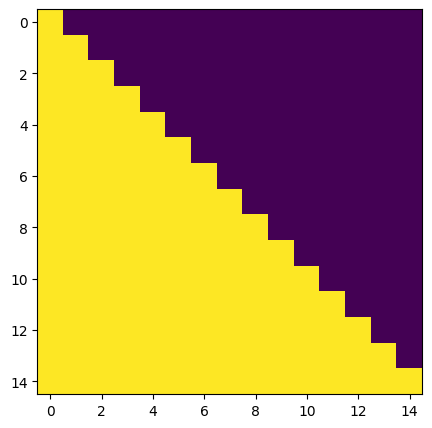

In [66]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(15)[0])

# attention

In [82]:
def attention(query, key, value, mask=None, dropout=None):
    # 取query最后一维的大小，一般等于词嵌入的维度
    # 注意这里的dropout指的是实例化对象而不是比例
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) #注意matmul的拼写，注意mul中是u

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9) # 用负的无穷大的数值做mask,这里的mask是一个变量对应mask矩阵的名字，具体见下一个markdown块的展示
    
    #对score的最后一维做softmax（F是torch.nn.funtional的缩写，用于计算损失函数之类的）
    p_attn = F.softmax(scores, dim=-1)

    if dropout is not None:
        p_attn = dropout(p_attn)

    attn = torch.matmul(p_attn, value)
    
    return attn, p_attn

basic function(mask)

In [72]:
x = Variable(torch.randn(5,5))
mask145 = Variable(torch.zeros(5,5))
y = x.masked_fill(mask145 == 0, -1e9)

tensor([[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]])

In [88]:
query = key = value = pe_result
# mask = torch.zeros
attn, p_attn = attention(query, key, value)
attn, attn.shape, p_attn

(tensor([[[  8.7440,   0.0000, -22.2175,  ...,   0.0000,  -1.9133, -23.7333],
          [-28.4508, -40.4319,  -5.9083,  ..., -20.9008,  38.4896, -30.3848],
          [ 24.1922, -10.6399, -25.2652,  ...,   5.0809, -12.5333,  56.6777],
          [ 12.7050, -28.6932,   8.7650,  ...,  10.3732, -45.7684, -22.8124]],
 
         [[ 10.3935, -30.7260,  -8.7050,  ...,   4.7604,  24.0184,  42.8854],
          [-25.8154,  27.6331,  24.5431,  ...,  36.2785,  24.1297,  -3.6109],
          [  2.3628,  -5.7436,   1.7906,  ..., -16.0706,  28.7144, -13.3701],
          [ 18.2173, -34.0497,  21.9660,  ...,   0.0000, -25.6206,  -4.7242]]],
        grad_fn=<UnsafeViewBackward0>),
 torch.Size([2, 4, 512]),
 tensor([[[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]],
 
         [[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>))

In [90]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(d_k) #(L*d)➡️(L*L)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9) #被mask的地方不能被注意

    p_attn = F.softmax(scores, dim=-1)

    if dropout is not None:
        p_attn = dropout(p_attn)

    return torch.matmul(p_attn, value), p_attn #注意力是注意力分数结合到文本的表示，不只有权重，还包含语义信息（QK的计算为了权重，V的计算融合语义）

In [111]:
query = key = value = pe_result
# mask = torch.zeros(2,4,4) #用全零mask掉就完全看不到attn，所有东西权重是一样的
mask = subsequent_mask(4)
attn, p_attn = attention(query, key, value, mask=mask) #可以把第一个输出自动命名为attn
attn, attn.shape, p_attn, mask
# pe_result, pe_result.shape

(tensor([[[  8.7440,  -0.0000, -22.2175,  ...,  -0.0000,  -1.9133, -23.7333],
          [-28.4508, -40.4319,  -5.9083,  ..., -20.9008,  38.4896, -30.3848],
          [ 24.1922, -10.6399, -25.2652,  ...,   5.0809, -12.5333,  56.6777],
          [ 12.7050, -28.6932,   8.7650,  ...,  10.3732, -45.7684, -22.8124]],
 
         [[ 10.3935, -30.7260,  -8.7050,  ...,   4.7604,  24.0184,  42.8854],
          [-25.8154,  27.6331,  24.5431,  ...,  36.2785,  24.1297,  -3.6109],
          [  2.3628,  -5.7436,   1.7906,  ..., -16.0706,  28.7144, -13.3701],
          [ 18.2173, -34.0497,  21.9660,  ...,   0.0000, -25.6206,  -4.7242]]],
        grad_fn=<MulBackward0>),
 torch.Size([2, 4, 512]))

# MutiHead Attn

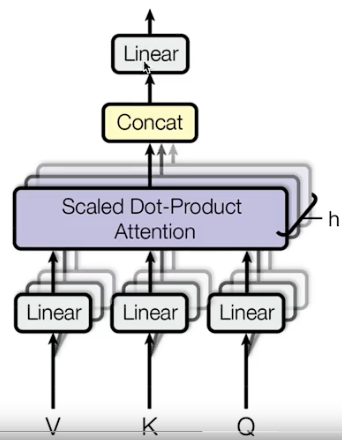

**这里有一个很有意思的事：** 240302

具体实现的时候每个head的d是总体embedding深度d/n，n指的是head的数量

就是说，设置head的数量之后，*我们通过计算设置每个head的深度维度大小为d/n*

这和kernel的概念非常像（但它们在实现细节和应用上有所区别。每个头确实可以捕捉不同的特征，但这是通过处理数据的不同子集并应用不同的线性变换来实现的，而不是通过在整个数据上滑动。）


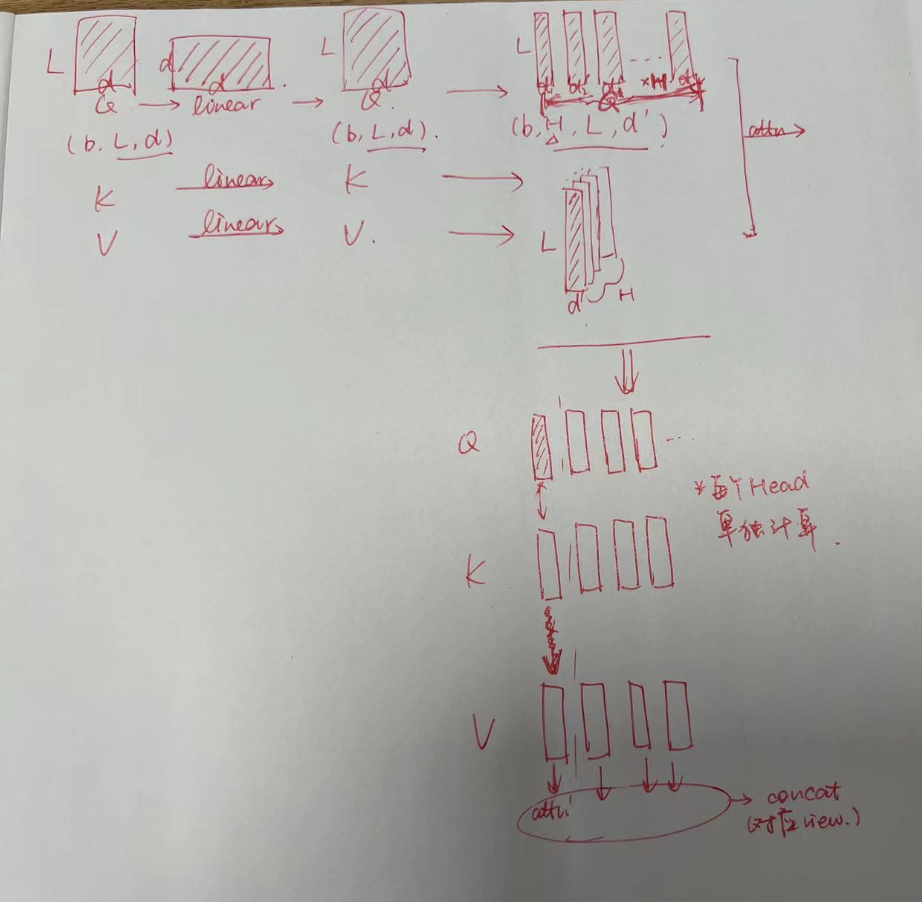

In [99]:
import copy #用于深度拷贝，复制的结果占用不同内存（如果直接赋值的话占用的是同一块内存）

def clones(module, N): #把module拷贝n份
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [115]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, head, embedding_dim, dropout=0.1): #head指的是注意力头的数量
        super().__init__()
        
        # 判断头数能不能被维度整除
        assert embedding_dim % head == 0
        self.d_k = embedding_dim // head #函数中使用的深度d是这里计算出来的

        self.head = head

        # 多头注意力机制中通过d*d方阵连接，和方阵相乘能够保证形状不变；把全连接机制复制四次，QKV各需要一个，最后的concat还需要一个
        # self.linears表示连续四个线性层
        self.linears = clones(nn.Linear(embedding_dim, embedding_dim), 4)

        self.attn = None #随后在forward函数再赋值
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None): #多头注意力机制真正计算的参数
        
        batch_size = query.size(0)

        # 核心，此时还没有计算attn
        # 把qkv分别过了一遍线性层，并按照想要的“头数”进行分割      # 所以“多头”并不是计算了多个qkv，而是原始数据按照想要的“头数”分成n份计算注意力分数
        query, key, value = \
            [model(x).view(batch_size, -1, self.head, self.d_k).transpose(1,2) #把下述for循环中的model和x进行处理；view进行维度划分 让输出的张量符合既定形式，-1对应的维度自适应（自适应表示的是长度的维度）；这里相当于把qkv按照head数量的份数进行划分了，整体数据增加了一维       #转置后句子长度和词向量（深度）能够相邻，以便注意力机制找到词义与句子位置的关系。
             for model, x in zip(self.linears, (query, key, value))] #zip把qkv和linear结合到一起，取linear和qkv分别叫做model和x（copy了4个 用了3个）
        
        # 调用之前的attn函数
        if mask is not None:
            mask = mask.unsqueeze(1)  #拓展维度，代表多头中的第n头(每一个mask矩阵的维度应该和分完head的L*d‘对应)
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        x = x.transpose(1,2).contiguous().view(batch_size, -1, self.head * self.d_k) 
        #把之前的转置回来 #先转置后view的时候需要使用contiguous连接（如果反过来不需要）


        # 用最后一个线性层对输出进行线性变换（copy了4个，之前qkv用了3个）
        return self.linears[-1](x)

In [118]:
query = key = value = pe_result
mask = subsequent_mask(4) #4对应的是表示文本长度的L维度
mha = MultiHeadedAttention(head=8, embedding_dim=512, dropout=0.2)
mha_result = mha(query, key, value, mask=None)
mha_result, mha_result.shape

(tensor([[[ -0.3265,   4.9875,  -7.5722,  ...,  11.0557,  15.4732, -10.5350],
          [  1.5469,  -0.5016,   2.4093,  ...,  11.7342,   3.9259,  13.0191],
          [ -3.7408,  -4.0964,   3.9437,  ...,   9.5589,   0.8695,   9.0424],
          [  6.2567,  -0.1488,  -6.2773,  ...,  -9.2196,   7.5481,  -8.3701]],
 
         [[ -6.9604,  -8.6874,   3.6199,  ...,   6.5447, -15.8510,   0.5569],
          [ -5.6563,  -6.1390,   4.1776,  ...,   7.9467,   0.3217, -14.2782],
          [  5.4103,  -0.7300,   9.4796,  ...,  -3.4576,  -7.3114,   2.1780],
          [ -0.3369,   1.8879, -15.6927,  ..., -11.2049,  -0.9306,  -0.2610]]],
        grad_fn=<ViewBackward0>),
 torch.Size([2, 4, 512]))